In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpl_patches
from scipy.optimize import curve_fit
      

In [2]:
def petroleum_initial_in_place(Nfoi, Gfgi, Rv, Rs):
  
  Rvi, Rsi = Rv[0], Rs[0]
  OOIP = Nfoi + Gfgi * Rvi
  OGIP = Gfgi + Nfoi * Rsi

  labels = []
  labels.append("Nfoi = {0:.4g} STB".format(Nfoi))
  labels.append("Gfgi = {0:.4g} SCF".format(Gfgi))
  labels.append("OOIP = {0:.4g} STB".format(OOIP))
  labels.append("OGIP = {0:.4g} SCF".format(OGIP))

  handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                  lw=0, alpha=0)] * 4
  return labels, handles, OOIP, OGIP   

In [3]:
class oil():
    """
    Oil (Undersaturated and saturated; Volatile and Non-volatile) Material Balance Plot
    """
    def calculate_params(self, p, Bo, Bg, Rv, Rs, Np, Gp, Gi, cf, cw, swi):
        """
        Calculate Material Balance Paramaters for Oil Reservoir
        
        Output: F, Bto, Btg, Efw, Eo, Eg
        """
        pi = p[0]
        Rsi = Rs[0]
        Rvi = Rv[0]
        Boi = Bo[0]
        Bgi = Bg[0]

        # calculate Efw
        Efw = ((cf + cw * swi) / (1 - swi)) * (pi - p)

        # calculate F, Bto, and Btg
        F = (Np * ((Bo - (Rs * Bg)) / (1 - (Rv * Rs)))) + ((Gp - Gi) * ((Bg - (Rv * Bo)) / (1 - (Rv * Rs))))
        Btg = ((Bg * (1 - (Rs * Rvi))) + (Bo * (Rvi - Rv))) / (1 - (Rv * Rs))  # in RB/STB
        Bto = ((Bo * (1 - (Rv * Rsi))) + (Bg * (Rsi - Rs))) / (1 - (Rv * Rs))  # in RB/scf

        # calculate Eo and Eg
        Eo = Bto - Boi
        Eg = Btg - Bgi

        return F, Bto, Btg, Efw, Eo, Eg

    def gascap(self, Gfgi, Nfoi, Bg, Bo):
      """
      Calculate Total Oil+Gas Expansion Factor from known Gas Cap ratio
      Gfgi and Nfoi known from volumetrics
      """
      Bgi, Boi = Bg[0], Bo[0]

      m = (Gfgi * Bgi) / (Nfoi * Boi)
      return m

    def plot(self, oil_type, F, Bto, Btg, Efw, Eo, Eg, Np, Bo, Rs, Rv, start=0, end=-1, figsize=(10,5)):
      """
      Create Material Balance Plots for Oil Reservoir
      
      Input:
      oil_type: 'undersaturated' or 'saturated'
      """
      # plot attributes
      title_size = 15
      title_pad = 14

      # linear function for curve-fit
      def linear_zero_intercept(x, m):
          y = m * x
          return y

      def linear_with_intercept(x, m, c):
          y = m * x + c
          return y

      if oil_type == 'undersaturated':

        plt.figure(figsize=figsize)

        " Plot 1: F vs (Eg+Boi*Efw) "

        plt.subplot(1,2,1)
        Boi = Bo[0]
        x1, y1 = (Eg + Boi * Efw), F
        plt.plot(x1, y1, '.-')
        plt.title(r'Plot 1: $F$ vs $(E_o+B_{oi}*E_{fw})$', size=title_size, pad=title_pad)
        plt.xlabel(r'$E_o+B_{oi}E_{fw}$ (RB/STB)', size=15)
        plt.ylabel(r'$F$ (res bbl)', size=15)

        ## curve-fitting to calculate the slope as OOIP
        x1_norm = x1 / max(x1) # normalize x
        y1_norm = y1 / max(y1) # normalize y

        x1_norm = x1_norm[start:end]
        y1_norm = y1_norm[start:end]

        popt, pcov = curve_fit(linear_zero_intercept, x1_norm, y1_norm)

        m = popt[0]
        Nfoi = m * max(y1) / max(x1) # denormalize the slope, hence the OGIP

        ## Calculate OOIP and OGIP from Nfoi
        Rsi = Rs[0]
        Gfgi = 0 # no free gas phase in undersaturated oil
        OOIP = Nfoi
        OGIP = Nfoi * Rsi

        ## Output results into text in plot
        labels, handles, OOIP, OGIP = petroleum_initial_in_place(Nfoi, Gfgi, Rv, Rs)    

        ## plot the regression line
        x1_fit = np.linspace(min(x1), max(x1), 5)
        y1_fit = linear_zero_intercept(x1_fit, Nfoi)
        plt.plot(x1_fit, y1_fit, label='{} MMSTB'.format(np.round(Nfoi * 1E-6, 3)))

        plt.legend(handles, labels, loc='best', fontsize='small', 
                   fancybox=True, framealpha=0.7, 
                   handlelength=0, handletextpad=0) 

        " Plot 2: F/(Eg+Boi*Efw) vs Np (Waterdrive Diagnostic Plot) "

        plt.subplot(1,2,2)
        x2, y2 = Np, F / (Eg + Boi * Efw)
        plt.plot(x2, y2, '.-')
        plt.title('Plot 2: Waterdrive Diagnostic Plot', size=title_size, pad=title_pad)
        plt.xlabel(r'$N_p$ (STB)', size=15)
        plt.ylabel(r'$\frac{F}{(E_o+B_{oi}E_{fw})}$ (STB)', size=15)

        ## curve-fitting to calculate the slope as OOIP, here [1:] because NaN is removed
        x2_norm = x2[1:] / max(x2[1:]) # normalize x
        y2_norm = y2[1:] / max(y2[1:]) # normalize y
        popt, pcov = curve_fit(linear_with_intercept, x2_norm, y2_norm)

        m, c = popt[0], popt[1]
        m = m * max(y2[1:]) / max(x2[1:]) # denormalize the slope
        Nfoi = c * max(y2[1:]) # denormalize the intercept, hence the OGIP

        ## Calculate OOIP and OGIP from Nfoi
        Rsi = Rs[0]
        Gfgi = 0 # no free gas phase in undersaturated oil
        OOIP = Nfoi
        OGIP = Nfoi * Rsi

        ## Output results into text in plot
        labels, handles, OOIP, OGIP = petroleum_initial_in_place(Nfoi, Gfgi, Rv, Rs)           

        ## plot the regression line
        x2_fit = np.linspace(min(x2[1:]), max(x2[1:]), 5)
        y2_fit = linear_with_intercept(x2_fit, m, Nfoi)
        plt.plot(x2_fit, y2_fit, label='{} MMSTB'.format(np.round(Nfoi * 1E-6, 3)))

        plt.legend(handles, labels, loc='best', fontsize='small', 
                   fancybox=True, framealpha=0.7, 
                   handlelength=0, handletextpad=0)  
        
        plt.tight_layout(1)
        plt.show()

      if oil_type == 'saturated':

        plt.figure(figsize=figsize)

        " Plot 1: F/Eo vs Eg/Eo "

        plt.subplot(1,3,1)
        x1, y1 = (Eg / Eo), (F / Eo)
        plt.plot(x1, y1, '.-')
        plt.title('Plot 1: F/Eo vs Eg/Eo', size=title_size, pad=title_pad)
        plt.xlabel(r'$\frac{Eg}{Eo}$ (STB/scf)', size=15)
        plt.ylabel(r'$\frac{F}{Eo}$ (STB)', size=15)

        ## curve-fitting to calculate the slope as Gfgi, intercept as Nfoi
        x1_norm = x1[1:] / max(x1[1:]) # normalize x
        y1_norm = y1[1:] / max(y1[1:]) # normalize y
        popt, pcov = curve_fit(linear_with_intercept, x1_norm, y1_norm)

        m, c = popt[0], popt[1]
        Gfgi = m = m * max(y1[1:]) / max(x1[1:]) # denormalize the slope
        Nfoi = c = c * max(y1[1:]) # denormalize the intercept

        ## calculate OOIP and OGIP from Nfoi and Gfgi
        Rsi, Rvi = Rs[0], Rv[0]
        OOIP = Nfoi + Gfgi * Rvi
        OGIP = Gfgi + Nfoi * Rsi

        ## Output results into text in plot
        labels, handles, OOIP, OGIP = petroleum_initial_in_place(Nfoi, Gfgi, Rv, Rs)    

        ## plot the regression line
        x1_fit = np.linspace(min(x1[1:]), max(x1[1:]), 5)
        y1_fit = linear_with_intercept(x1_fit, m, c)
        plt.plot(x1_fit, y1_fit)

        plt.legend(handles, labels, loc='best', fontsize='small', 
                   fancybox=True, framealpha=0.7, 
                   handlelength=0, handletextpad=0)

        " Plot 2: p/z vs Gp "

        plt.subplot(1,3,2)
        x2, y2 =  (Eo / Eg), (F / Eg)
        plt.plot(x2, y2, '.-')
        plt.title('Plot 2: F/Eg vs Eo/Eg', size=title_size, pad=title_pad)
        plt.xlabel(r'$\frac{Eo}{Eg}$ (scf/STB)', size=15)
        plt.ylabel(r'$\frac{F}{Eg}$ (scf)', size=15)

        ## curve-fitting to calculate the slope as Nfoi, intercept as Gfgi
        x2_norm = x2[1:] / max(x2[1:]) # normalize x
        y2_norm = y2[1:] / max(y2[1:]) # normalize y
        popt, pcov = curve_fit(linear_with_intercept, x2_norm, y2_norm)

        m, c = popt[0], popt[1]
        Nfoi = m = m * max(y2[1:]) / max(x2[1:]) # denormalize the slope
        Gfgi = c = c * max(y2[1:]) # denormalize the intercept

        ## calculate OOIP and OGIP from Nfoi and Gfgi
        Rsi, Rvi = Rs[0], Rv[0]
        OOIP = Nfoi + Gfgi * Rvi
        OGIP = Gfgi + Nfoi * Rsi

        ## Output results into text in plot
        labels, handles, OOIP, OGIP = petroleum_initial_in_place(Nfoi, Gfgi, Rv, Rs)    

        ## plot the regression line
        x2_fit = np.linspace(min(x2[1:]), max(x2[1:]), 5)
        y2_fit = linear_with_intercept(x2_fit, m, c)
        plt.plot(x2_fit, y2_fit)

        plt.legend(handles, labels, loc='best', fontsize='small', 
                   fancybox=True, framealpha=0.7, 
                   handlelength=0, handletextpad=0) 

        plt.tight_layout(1)                 

        plt.show()   

In [4]:
# Read the example of data for oil undersaturated reservoir
df = pd.read_csv('updated_oilres_data.csv')
df

,date,z,p,Np,Wp,Wi,Gp,Bo,Rs
0,1996,0.700638,1950,360085,1845.00,0,23045000,1.081087,64
1,1997,0.702142,1834,17230861,39236.00,0,1102775000,1.081213,64
2,1998,0.708127,1681,38651717,97909.00,0,2473713000,1.081405,64
3,1999,0.716362,1560,68957151,254876.00,0,4413261000,1.081583,64
4,2000,0.724264,1473,95057167,297686.00,38824,6083661000,1.081730,64
5,2001,0.737850,1353,124251053,673783.00,12197536,7952070000,1.081963,64
6,2002,0.746588,1287,154528553,1011278.00,25395003,9889832000,1.082109,64
7,2003,0.752293,1247,191899252,2253789.00,50762076,12281556000,1.082206,64
8,2004,0.753470,1239,229090690,3898144.00,83580287,14661809000,1.082226,64
9,2005,0.754658,1231,265394171,5591112.00,115457824,16985232000,1.082246,64


In [5]:
# Units conversion
t = df['date'].values
p = df['p'].values
z = df['z'].values
Np = df['Np'].values 
Gp = df['Gp'].values
Bo = df['Bo'].values
Rs = df['Rs'].values


In [6]:
# no injection, define Gi as zeros
Gi = np.zeros(len(df))
# because non-volatile, add Rv data as zeros
Rv = np.zeros(len(df))

In [7]:
# Gas FVF Calculation
def gas_fvf(z, temp, pressure):
  temp = temp + 459.67
  Bg = 0.0282793 * z * temp / pressure 
  return(Bg)

In [8]:
# Bg calculation from z-factor
temp = 195 # Initial reservoir temperature, Fahrenheit
Bg = gas_fvf(z, temp, p)
#Bg = Bg * 0.18 # convert res ft3/scf to RB/scf
df['Bg'] = Bg

In [9]:
swi = 0.2 # Initial water saturation
cw = 3E-6 # Water compressibility, sip
cf = 50E-6 # Formation compressibility, sip

In [10]:
# Initialize oil reservoir typ
type = oil()

In [11]:
# MBAL parameters calculation
F, Bto, Btg, Efw, Eo, Eg = oil.calculate_params(type, p, Bo, Bg, Rv, Rs, Np, Gp, Gi, cf, cw, swi)

C:\Users\vys\AppData\Local\Temp\ipykernel_14512\998442080.py:108: RuntimeWarning: divide by zero encountered in true_divide
  x2, y2 = Np, F / (Eg + Boi * Efw)


TypeError: tight_layout() takes 0 positional arguments but 1 was given

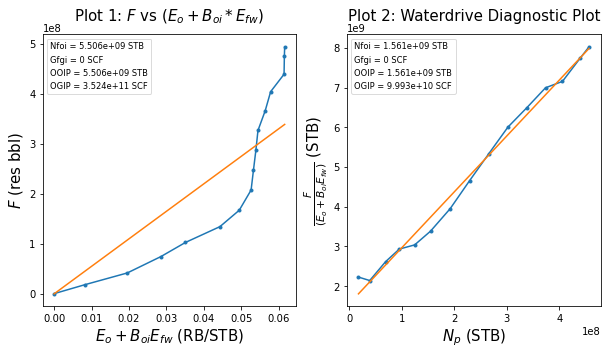

In [12]:
# Material balance plots
oil.plot(type, 'undersaturated', F, Bto, Btg, Efw, Eo, Eg, Np, Bo, Rs, Rv)
